In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

Global seed set to 0


In [2]:
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/Hepatocyte/final/"
)

FIG2SAVE = DIR2SAVE.joinpath("figures/forpaper/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [3]:
adata = sc.read_h5ad(
    DIR2SAVE.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Hepatocyte_final.h5ad"
    )
)
adata.shape

(437, 2000)

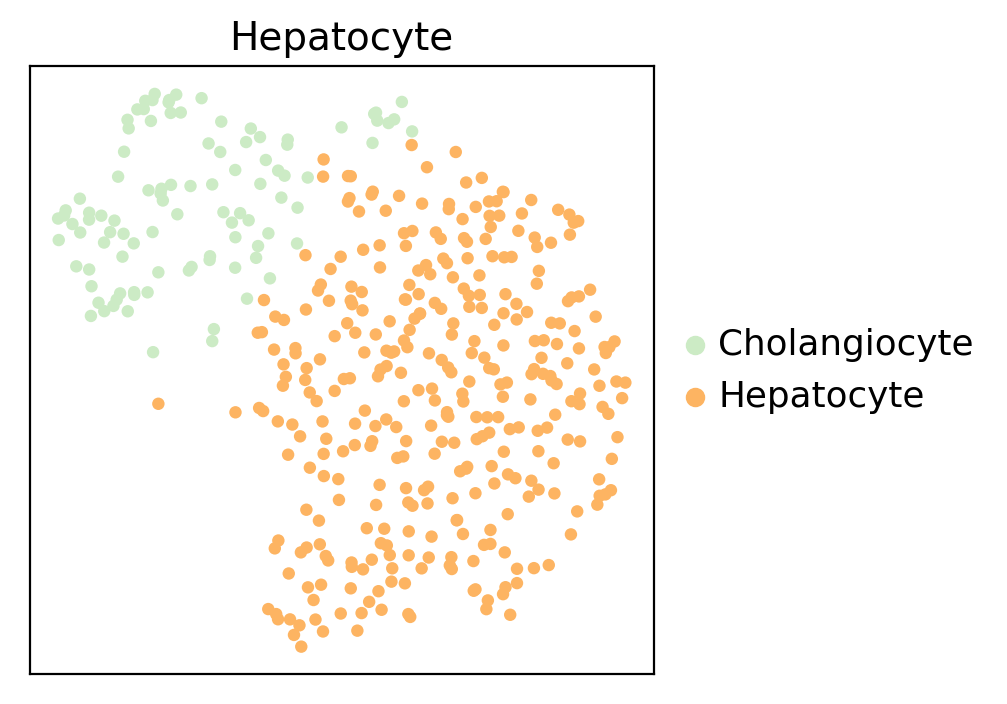

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sc.pl.umap(
    adata,
    color="Annotation_scVI_detailed",
    show=False,
    legend_loc="right margin",
    title="Hepatocyte",
    size=80,
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig(FIG2SAVE.joinpath("Annotation.pdf"), bbox_inches='tight', dpi=DPI)

In [5]:
from matplotlib.patches import Rectangle


def proportion_cells_patient(
    adata, groupby_labels, xlabel: str, ylabel: str, colors: dict, figname: str
):  # colors
    # compute proportion of cells within each group
    table2plot = (
        adata.reset_index()
        .groupby(groupby_labels)
        .size()
        .groupby(level=0)
        .apply(lambda x: x * 100 / x.sum())
        .unstack()
    )

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        sharey=False,
        sharex=False,
        dpi=DPI,
    )  # figsize=(4, 4))

    print(table2plot)
    table2plot.plot.barh(stacked=True, ax=ax, color=colors.values())  # , color=colors
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid(False, which="major", axis="both")  # removes major horizontal gridlinesd

    labels = list(colors.keys())
    l = [Rectangle((0, 0), 0, 0, color=color) for color in list(colors.values())]
    ax.legend(
        l,
        labels,
        loc="upper left",
        bbox_to_anchor=(1, 0.8),
        facecolor="white",
        edgecolor="white",
        ncol=1,
        borderaxespad=0.0,
        framealpha=0,
        frameon=False,
    )

    plt.savefig(FIG2SAVE.joinpath(figname), dpi=DPI, format="pdf", bbox_inches="tight")
    plt.show()

cell_source               BCI-Nuclei
Annotation_scVI_detailed            
Cholangiocyte                  100.0
Hepatocyte                     100.0


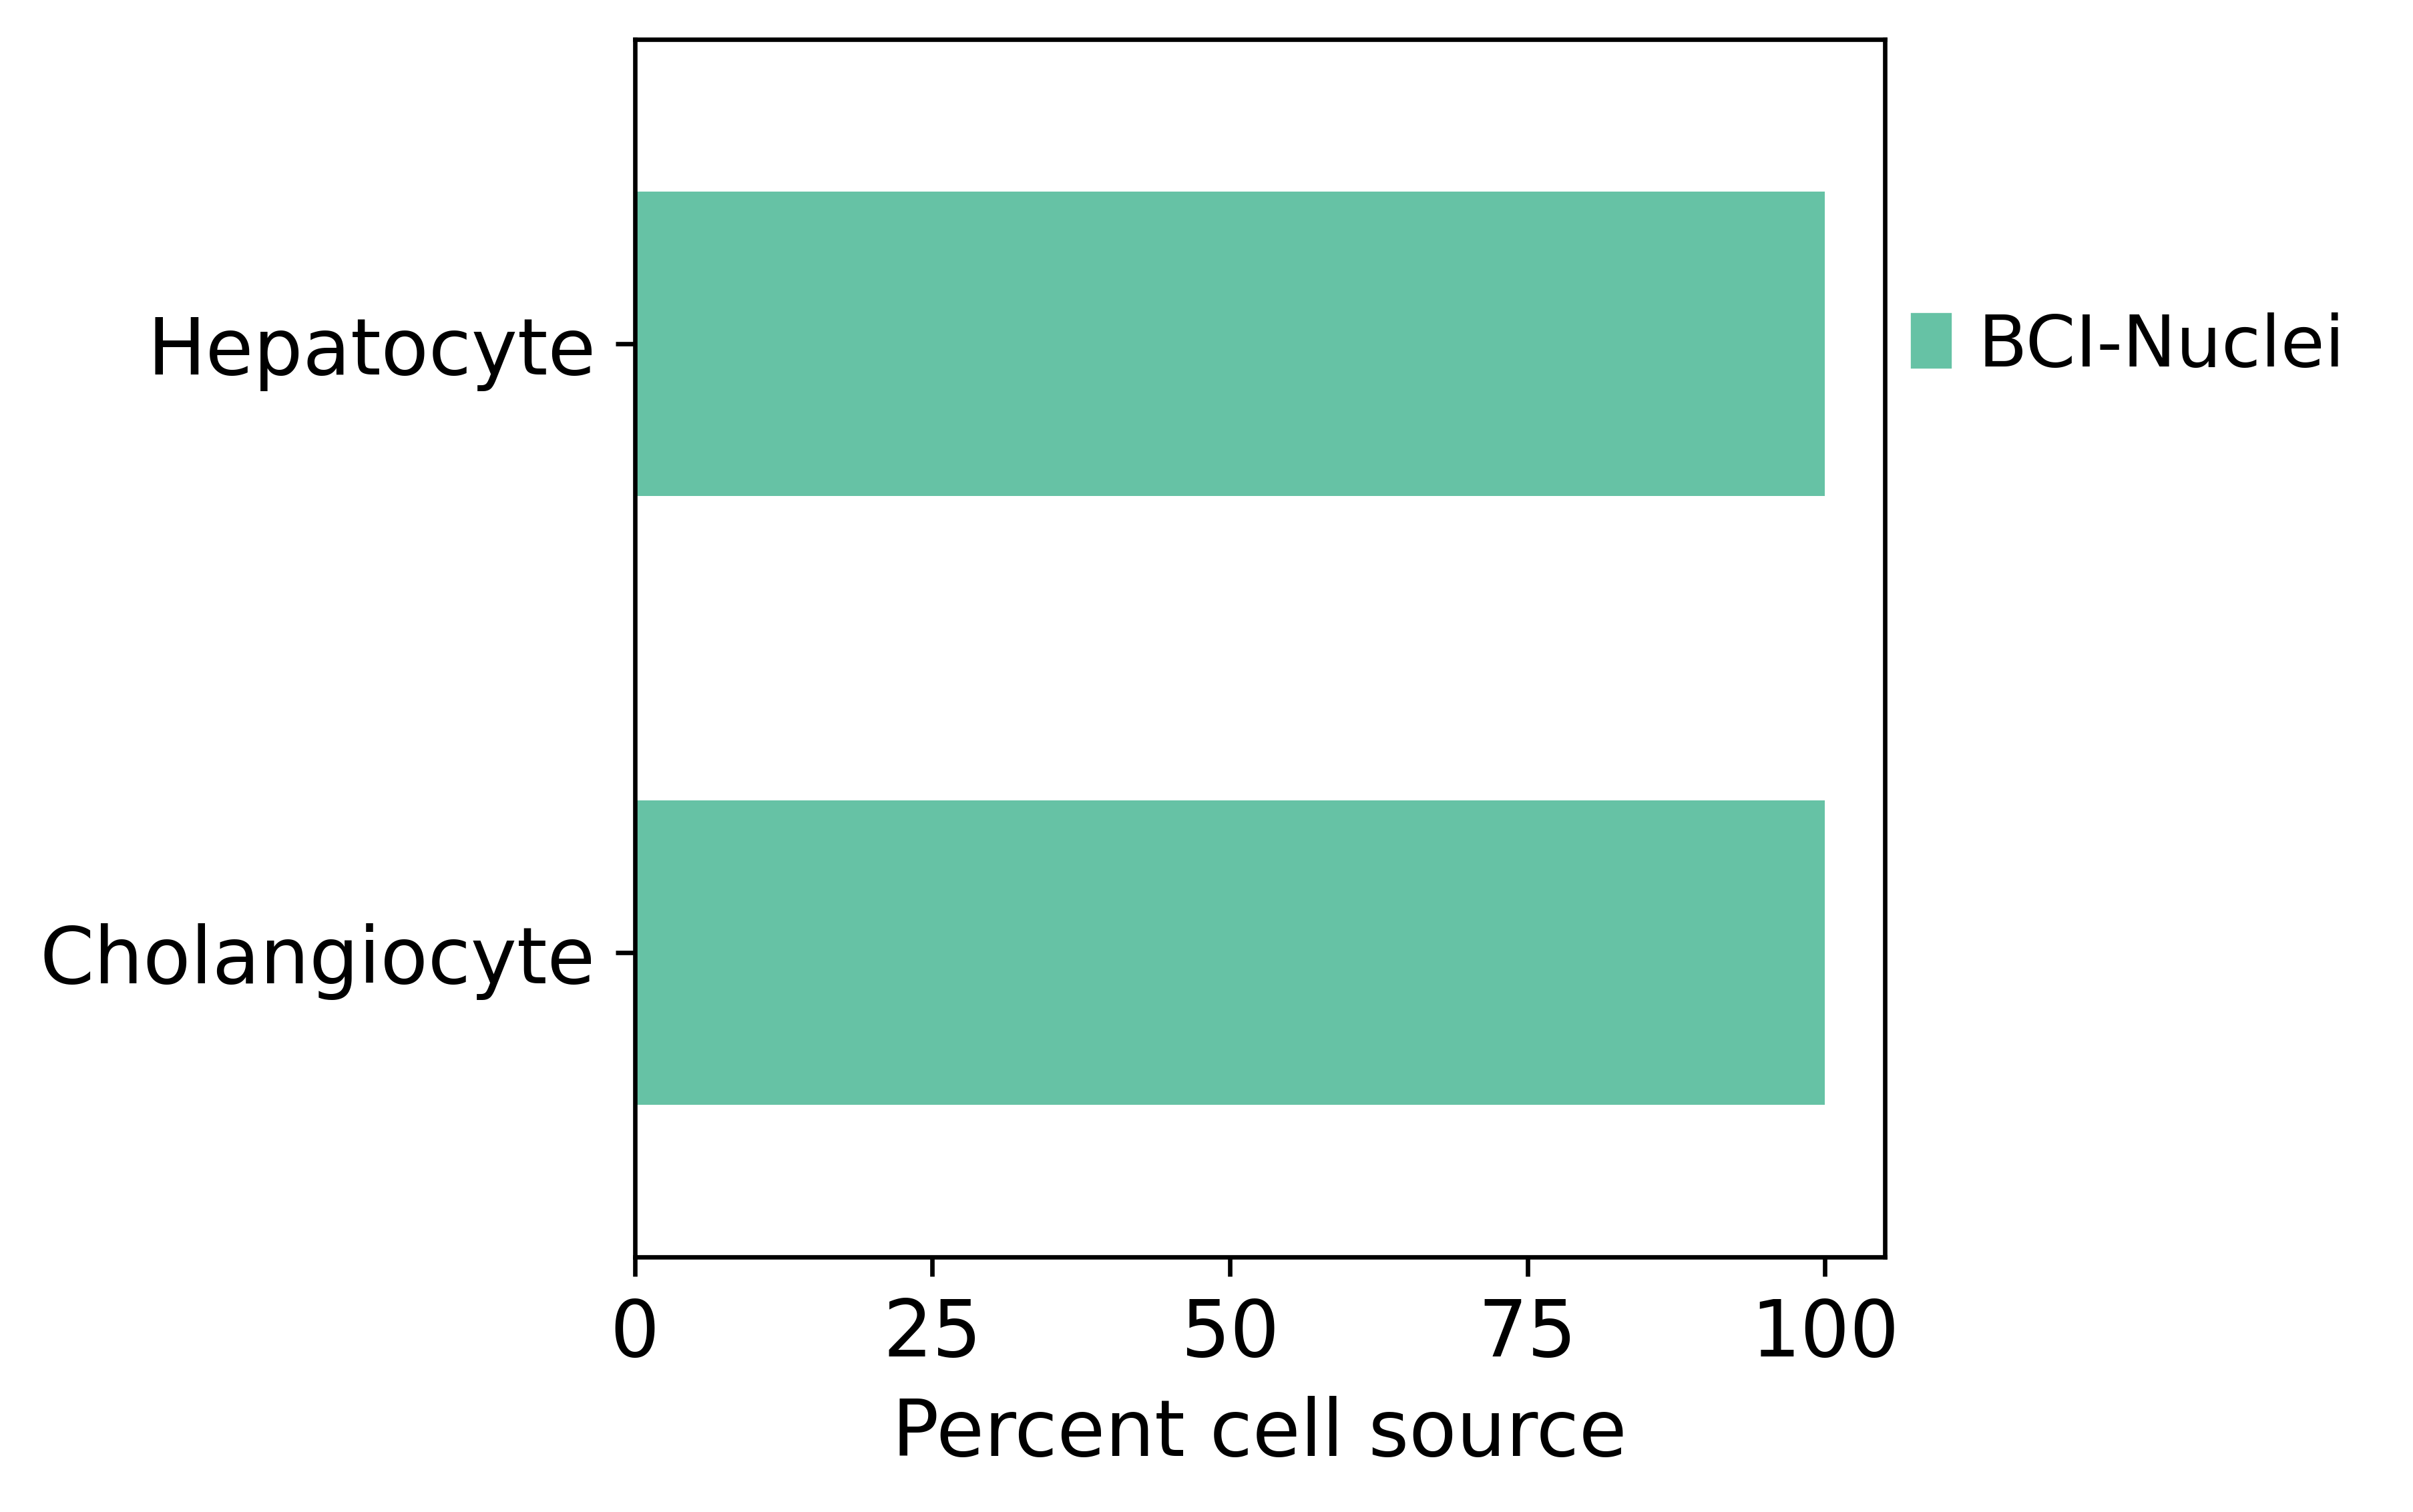

In [6]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["cell_source"].cat.categories.values.tolist(),
        adata.uns["cell_source_colors"],
    )
)

proportion_cells_patient(
    adata.obs,
    groupby_labels=["Annotation_scVI_detailed", "cell_source"],
    xlabel="Percent cell source",
    ylabel="",
    colors=color_dict,
    figname="annotation_cell_source.pdf",
)

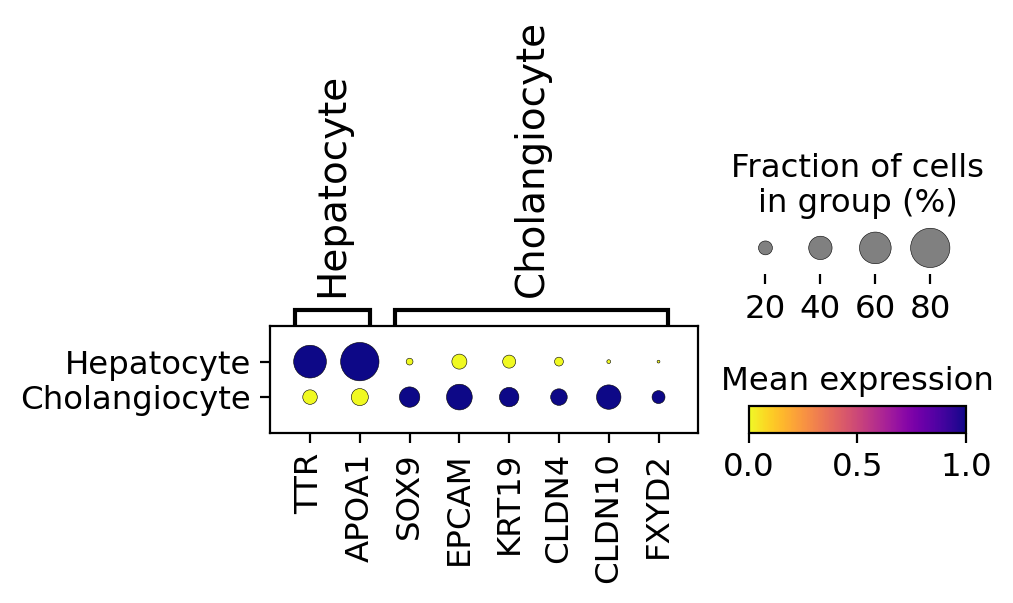

In [7]:
markers = {
    "Hepatocyte": ["TTR", "APOA1",],
    "Cholangiocyte": ["SOX9", "EPCAM", "KRT19", "CLDN4", "CLDN10", "FXYD2"],
}
sc.pl.dotplot(
    adata,
    groupby="Annotation_scVI_detailed",
    use_raw=True,
    var_names=markers,
    categories_order=markers.keys(),
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    dendrogram=False,
    save="dotplot_mean_general.pdf",
    show=True,
)

### zscore

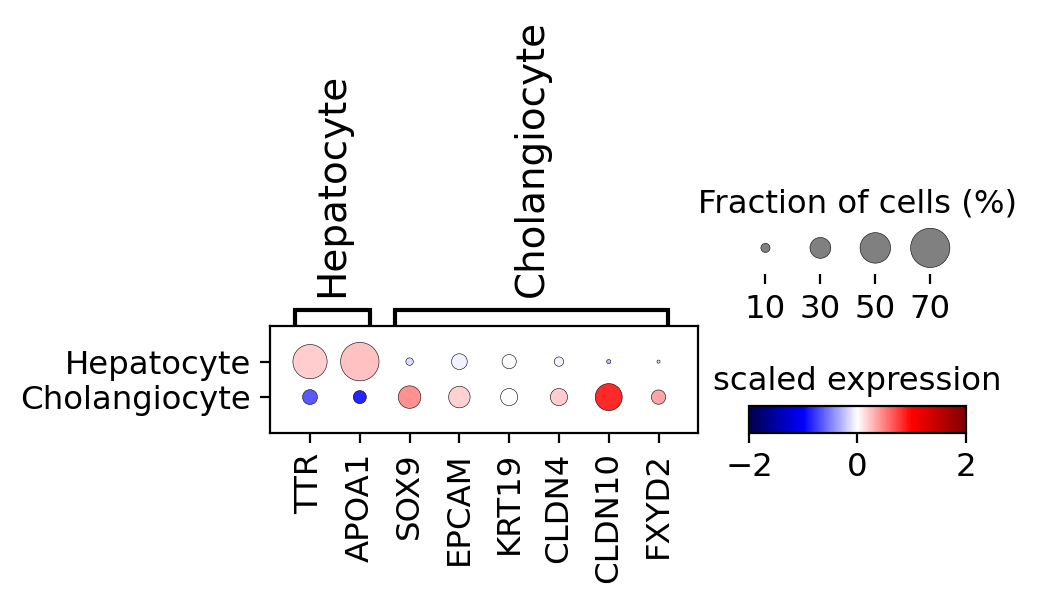

In [8]:
adata_zscore = adata.raw.to_adata().copy()
# scale and store results in layer for later plotting
adata_zscore.layers['scaled'] = sc.pp.scale(adata_zscore, copy=True).X
adata_zscore.obs=adata.obs
sc.pl.dotplot(adata=adata_zscore, 
              var_names=markers,
              categories_order=markers.keys(),
              groupby="Annotation_scVI_detailed",
              cmap="seismic", 
              layer="scaled", 
              vmin=-2,
              vmax=2, 
              dot_max=0.7, 
              colorbar_title = "scaled expression", 
              size_title="Fraction of cells (%)",
              save='zscore_general.pdf')

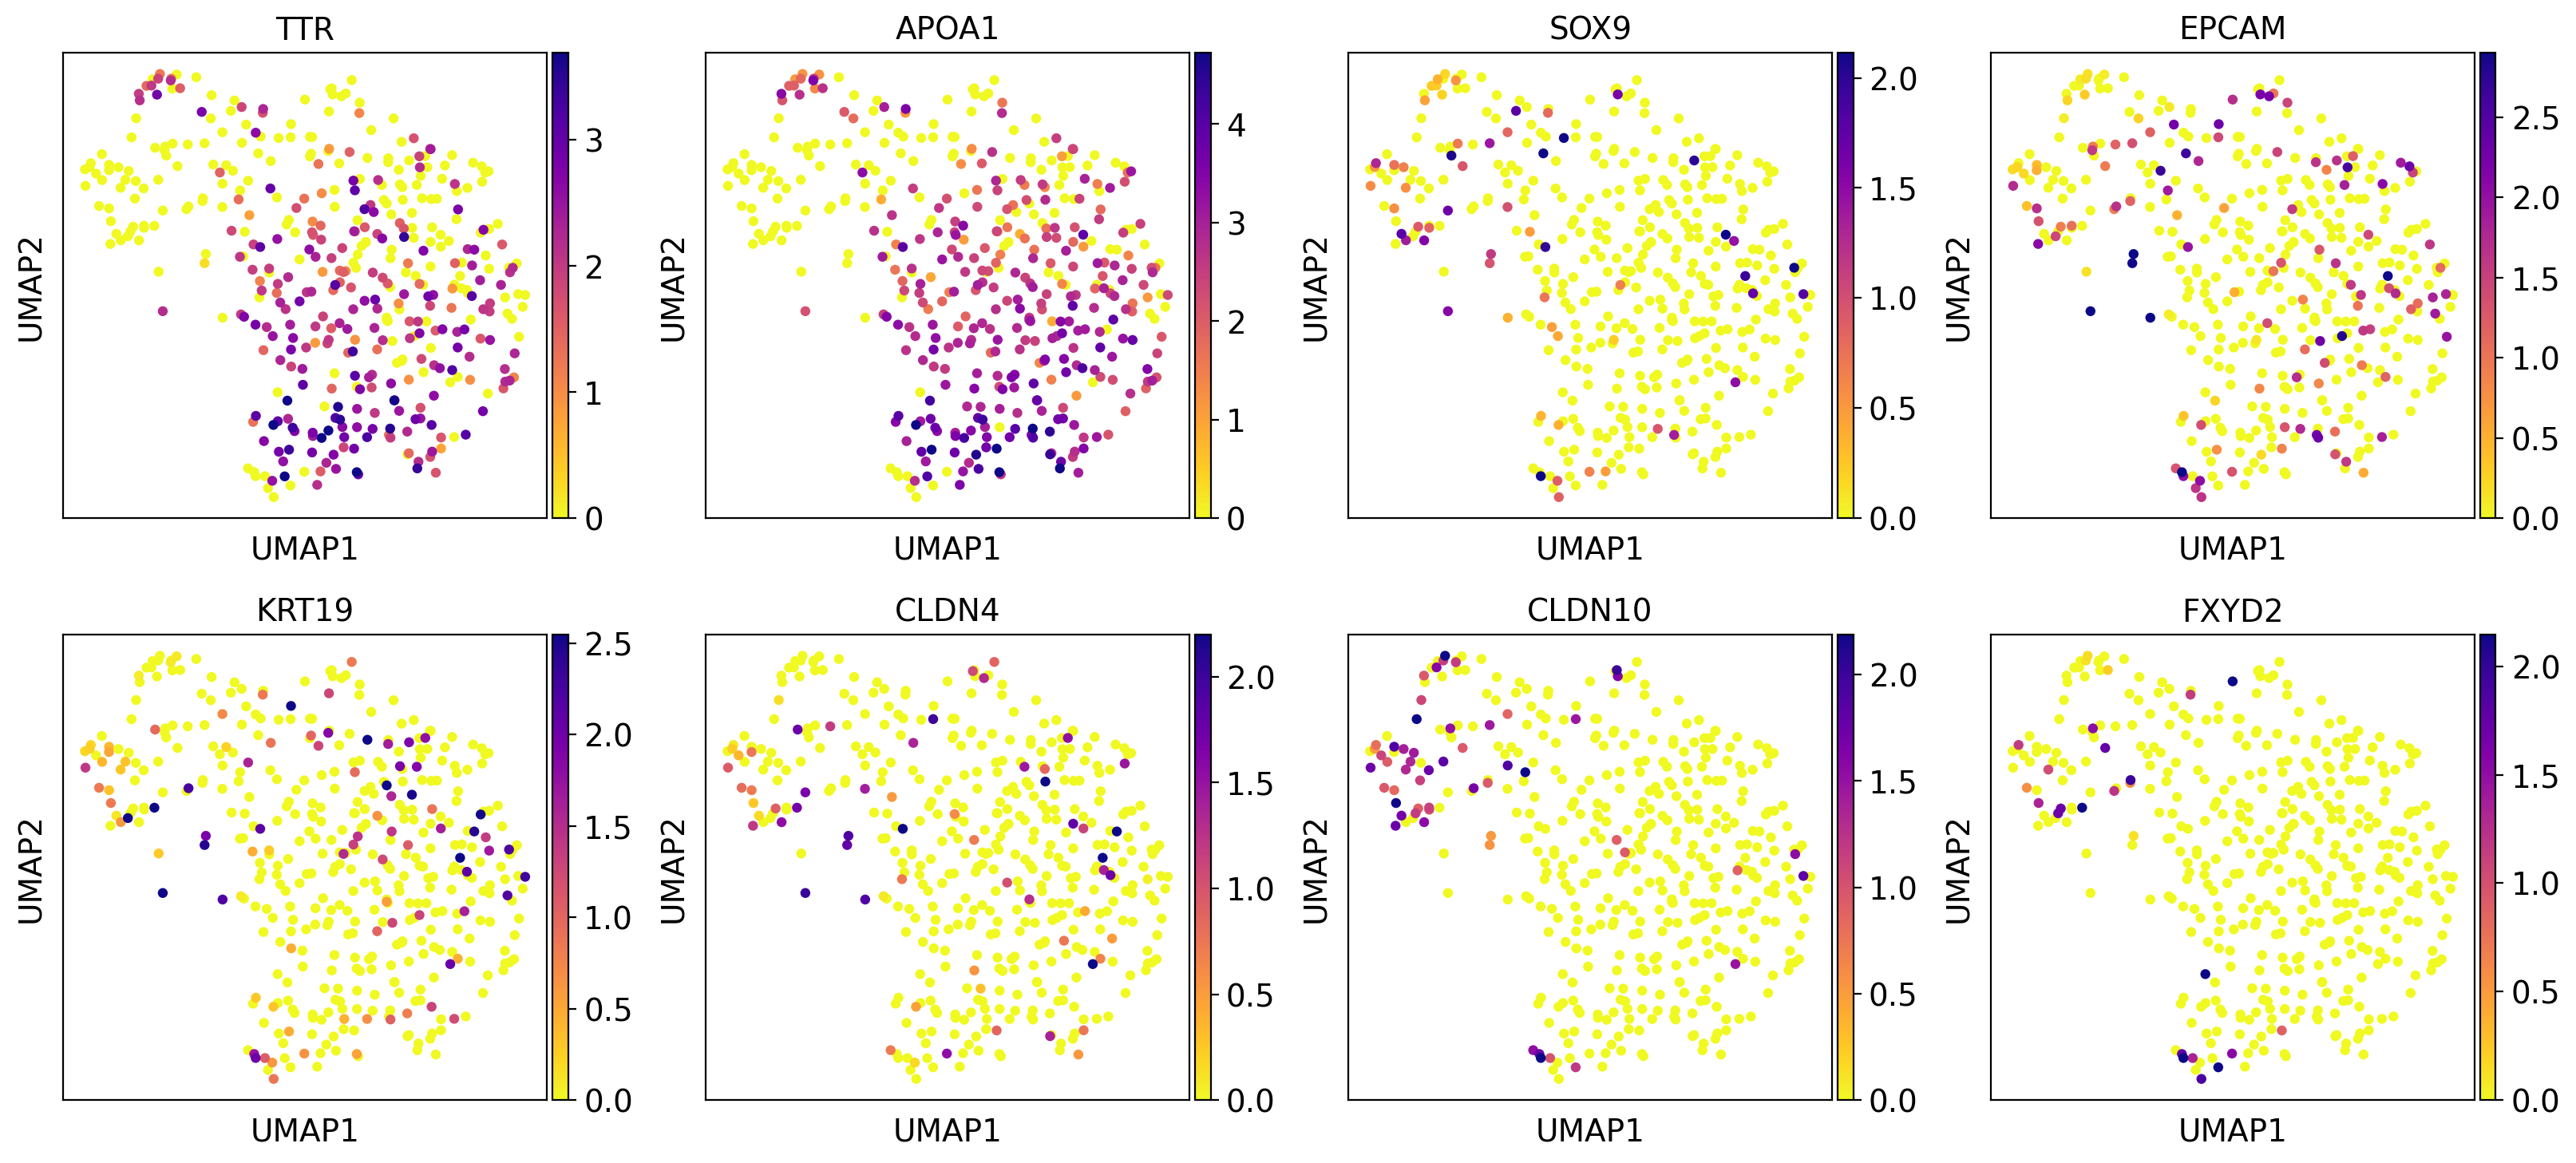

In [9]:
import itertools

# use log1p data stored in .raw
markers2plot = list(
    itertools.chain(*list(markers.values()))
)  # get all markers in a single list
sc.pl.umap(
    adata,
    color=markers2plot,
    use_raw=True,
    vmin=0.0,
    vmax="p99",
    color_map="plasma_r",  #'RdPu',
    save="general_markers.pdf",
    size=80,
    show=True,
)